In [1]:
import numpy as np
import math
# import random
import matplotlib.pyplot as plt
from sklearn import datasets, preprocessing

In [2]:
def dictionary_to_vector(parameters):
    """
    Roll all our parameters dictionary into a single vector satisfying our specific required shape.
    """
    keys = []
    count = 0
    for key in ["W1", "b1", "W2", "b2", "W3", "b3", "W4", "b4"]:
#     for key, value in parameters.items():
        
        # flatten parameter
        new_vector = np.reshape(parameters[key], (-1,1))
        keys = keys + [key]*new_vector.shape[0]
        
        if count == 0:
            theta = new_vector
        else:
            theta = np.concatenate((theta, new_vector), axis=0)
        count = count + 1

    return theta, keys

def vector_to_dictionary(theta, layer_dims):
    # need to do this programmatically
    """
    Unroll all our parameters dictionary from a single vector satisfying our specific required shape.
    """
    parameters = {}
    total = 0
    for i in range(1, len(layer_dims)):
        val = layer_dims[i]
        val_prev = layer_dims[i-1]
        parameters["W"+str(i)] = theta[:val*val_prev].reshape((val, val_prev))
        parameters["b"+str(i)] = theta[val*val_prev:val*val_prev+val].reshape((val, 1))
#         total += val*val_prev + val

#     parameters = {}
#     parameters["W1"] = theta[:12].reshape((3,4))      # 4, 3, 8, 5, 3
#     parameters["b1"] = theta[12:15].reshape((3,1))
#     parameters["W2"] = theta[15:39].reshape((8,3))
#     parameters["b2"] = theta[39:47].reshape((8,1))
#     parameters["W3"] = theta[47:87].reshape((5,8))
#     parameters["b3"] = theta[87:92].reshape((5,1))
#     parameters["W4"] = theta[92:107].reshape((3,5))
#     parameters["b4"] = theta[107:110].reshape((3,1))
    return parameters

def gradients_to_vector(gradients):
    """
    Roll all our gradients dictionary into a single vector satisfying our specific required shape.
    """
    
    count = 0
    for key in ["dW1", "db1", "dW2", "db2", "dW3", "db3", "dW4", "db4"]:
        # flatten parameter
        new_vector = np.reshape(gradients[key], (-1,1))
        
        if count == 0:
            theta = new_vector
        else:
            theta = np.concatenate((theta, new_vector), axis=0)
        count = count + 1

    return theta

def gradient_check_n(parameters, gradients, X, Y, layer_dims, lam, epsilon = 1e-7):
    """
    Checks if backward_propagation_n computes correctly the gradient of the cost output by forward_propagation_n
    
    Arguments:
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3":
    grad -- output of backward_propagation_n, contains gradients of the cost with respect to the parameters. 
    x -- input datapoint, of shape (input size, 1)
    y -- true "label"
    epsilon -- tiny shift to the input to compute approximated gradient with formula(1)
    
    Returns:
    difference -- difference (2) between the approximated gradient and the backward propagation gradient
    """

    # Set-up variables
    parameters_values, _ = dictionary_to_vector(parameters)
    grad = gradients_to_vector(gradients)
    num_parameters = parameters_values.shape[0]
    J_plus = np.zeros((num_parameters, 1))
    J_minus = np.zeros((num_parameters, 1))
    gradapprox = np.zeros((num_parameters, 1))
    
    # Compute gradapprox
    for i in range(num_parameters):
        thetaplus = np.copy(parameters_values)                                      # Step 1
        thetaplus[i][0] = thetaplus[i][0] + epsilon                                # Step 2
        AL_plus, _ = L_model_forward(X, vector_to_dictionary(thetaplus, layer_dims))
        J_plus[i] = compute_cost(AL_plus, Y, parameters, lam)
        
        thetaminus = np.copy(parameters_values)                                     # Step 1
        thetaminus[i][0] = thetaminus[i][0] - epsilon                               # Step 2   
        AL_minus, _ = L_model_forward(X, vector_to_dictionary(thetaminus, layer_dims))
        J_minus[i] = compute_cost(AL_minus, Y, parameters, lam)
        
        # Compute gradapprox[i]
        gradapprox[i] = (J_plus[i] - J_minus[i]) / (2 * epsilon)
#     for j in range(len(gradapprox)):
#         print(grad[j], gradapprox[j])
    # Compare gradapprox to backward propagation gradients by computing difference.
    numerator = np.linalg.norm(grad - gradapprox)                                            # Step 1'
    denominator = np.linalg.norm(grad) + np.linalg.norm(gradapprox)                                         # Step 2'
    difference = numerator / denominator                                           # Step 3'

    if difference > 1.2e-7:
        print ("\033[93m" + "There is a mistake in the backward propagation! difference = " + str(difference) + "\033[0m")
    else:
        print ("\033[92m" + "Your backward propagation works perfectly fine! difference = " + str(difference) + "\033[0m")
    
    return difference

In [3]:
def initialize_parameters(layer_dims):
# layers_dims: array containing dimensions of each layer ex initialize_parameters([5, 4, 3])

    np.random.seed(12)
    parameters = {}
    L = len(layer_dims) # number of layers in nn
    
    for l in range(1, L):
        # Xavier initialization, big help
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1]) #*0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))
        
    return parameters

def linear_forward(A, W, b):
    Z = np.dot(W, A) + b
        
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

def sigmoid(Z):
    A = 1 / (1 + np.exp(-Z))
    cache = Z
    return A, cache

def relu(Z):
    A = np.maximum(0, Z)

    assert(A.shape == Z.shape)
    cache = Z
    return A, cache

def softmax(Z):
    t = np.exp(Z)
    A = t / np.sum(t, axis=0)
    cache = Z
    
    return A, cache
    

def neuron_activation(A_prev, W, b, activation):
    if activation == 'sigmoid':
        Z, linear_cache = linear_forward(A_prev, W, b)
        # linear cache: A, W, b
        A, activation_cache = sigmoid(Z)
        # activation cache: Z
        
    elif activation == 'relu':
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
        
    elif activation == 'softmax':
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = softmax(Z)
        
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)
    
    return A, cache

def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2 # // is floor division
    
    for l in range(1, L):
        
        A_prev = A
        
        A, cache = neuron_activation(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], 'relu')
        caches.append(cache)

    AL, cache = neuron_activation(A, parameters['W' + str(L)], parameters['b' + str(L)], 'softmax')
    caches.append(cache)
    #change to programmatic
    assert(AL.shape == (3, X.shape[1])) #  (# of output classes x m)

    return AL, caches

def compute_cost(AL, Y, parameters, lam):
    m = Y.shape[1]
#     cost = (-1/m) * np.sum(Y*np.log(AL) + (1-Y)*np.log(1-AL))
    
#     cost = np.squeeze(cost)
#     assert(cost.shape == ())
    l2 = sum([ np.sum(np.square(v)) for k,v in parameters.items() ])
    l2 *= (1/m)*(lam/2)
    cost = (-1/m) * np.sum(Y * np.log(AL))
    cost += l2
    return cost
    
def linear_backward(dZ, cache, lam):
    A_prev, W, b = cache
    m = A_prev.shape[1]
    dW = (1/m) * np.dot(dZ, A_prev.T) + ((lam/m) * W)
#     dW = (1/m) * np.dot(dZ, A_prev.T)
    db = (1/m) * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True)
    
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)

    return dZ

def sigmoid_backward(dA, cache):
    Z = cache
    s = 1 / (1 + np.exp(-Z))
    dZ = dA * s * (1-s) # dLoss/dA * a(1-a) -- same as dLoss/dA * g_prime(Z)
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def softmax_backward(dA, cache):
    Z = cache
    dZ = dA
    
    assert (dZ.shape == Z.shape)

    return dZ

def linear_activation_backward(dA, cache, activation, lam):
    linear_cache, activation_cache = cache
    # check here for reverse grad shape bug
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache, lam)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache, lam)
       
    elif activation == 'softmax':
        dZ = softmax_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache, lam)
        
    return dA_prev, dW, db

def L_model_backward(AL, Y, caches, lam):
    grads = {}
    L = len(caches)
    m = AL.shape[1]
#     Y = Y.reshape(AL.shape)
    
#     dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL)) #derivative of cost function
    dAL = AL - Y # this is dZ for softmax, not dL/dA * g_prime(z)
    current_cache = caches[L-1]

    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, "softmax", lam)
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l+2)], current_cache, "relu", lam)
        grads["dA" + str(l+1)] = dA_prev_temp
        grads["dW" + str(l+1)] = dW_temp
        grads["db" + str(l+1)] = db_temp
            
    return grads

def update_parameters(parameters, grads, learning_rate, lam):
    L = len(parameters) // 2      
    for l in range(1, L+1):
        parameters['W'+str(l)] = parameters['W'+str(l)] - learning_rate * grads['dW'+str(l)]
        parameters['b'+str(l)] = parameters['b'+str(l)] - learning_rate * grads['db'+str(l)]

    return parameters

def predict(X, y, parameters):
    print('X', X.shape, 'Y.shape', y.shape)
    m = X.shape[1]
    n = len(parameters) // 2
    p = np.zeros((y.shape[0], m))
    acc = []
    probas, caches = L_model_forward(X, parameters)
    print('probas\n', probas.shape)
    # max for each example
    # search for index == max
    # assign 1 to that class and 0 to the others
    for i in range(0, probas.shape[1]):
        index = np.where(probas[:, i] == np.max(probas[:, i]))
        probas[index, i] = 1
        zeros = np.where(probas[:, i] != 1)
        probas[zeros, i] = 0
        if np.where(probas[:,i] == 1) == np.where(y[:,i] ==1):
            acc.append(True)
            
    print(type(probas))
    print("Accuracy: " + str(sum(acc)/m))
#     print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

In [4]:
def L_layer_model(X, Y, layer_dims, learning_rate = .0075, lam=0, num_iterations = 10, print_cost = False):
    np.random.seed(3)
    costs = []
    
    parameters = initialize_parameters(layer_dims)
    for i in range(0, num_iterations):
        AL, caches = L_model_forward(X, parameters)
        
        cost = compute_cost(AL, Y, parameters, lam)
        grads = L_model_backward(AL, Y, caches, lam)
        
        parameters = update_parameters(parameters, grads, learning_rate, lam)
        
        # Print the cost every 100 training example
        if print_cost and i % 10000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
            difference = gradient_check_n(parameters, grads, X, Y, layer_dims, lam)
            print(difference)
        if print_cost and i % 10000 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

In [5]:
# wine = datasets.load_wine(True)
# wine[0].shape[0]
# X = wine[0].T
# X = preprocessing.scale(X)

# Y_cat = wine[1]
# Y = []
# for i in Y_cat:
#     if i==0:
#         Y.append([1,0,0])
#     elif i == 1:
#         Y.append([0,1,0])
#     elif i == 2:
#         Y.append([0,0,1])
# Y = np.array(Y).T


In [6]:
# iris = datasets.load_iris(True)
# iris[0].shape[0]
# X = iris[0].T
# X = preprocessing.scale(X)

# Y_cat = iris[1]
# Y = []
# for i in Y_cat:
#     if i==0:
#         Y.append([1,0,0])
#     elif i == 1:
#         Y.append([0,1,0])
#     elif i == 2:
#         Y.append([0,0,1])
# Y = np.array(Y).T
# print('X.shape', X.shape)
# print('Y.shape', Y.shape)
# X.mean(axis=0)
# X.std(axis=0)

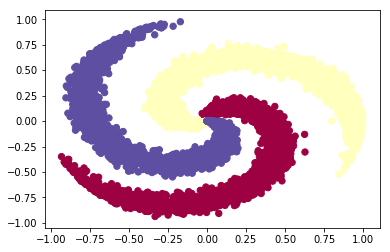

(3, 9000) (2, 9000)


In [7]:
N = 3000 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data:
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()
X = X.T
Y = []
for i in y:
    if i==0:
        Y.append([1,0,0])
    elif i == 1:
        Y.append([0,1,0])
    elif i == 2:
        Y.append([0,0,1])
Y = np.array(Y).T
print(Y.shape, X.shape)

In [8]:
np.random.seed(101)
split = np.random.rand(X.shape[1])

In [9]:

train = split < .7
test = split >= .7
X_train = X[:, train]
Y_train = Y[:, train]
X_test = X[:, test]
Y_test = Y[:, test]

# train = split < .6
# cv = (.6 <= split) & (split < .8)
# test = .8 <= split

# X_train = X[:, train]
# X_cv = X[:, cv]
# X_test = X[:, test]

# Y_train = Y[:, train]
# Y_cv = Y[:, cv]
# Y_test = Y[:, test]

print(X_train.shape, Y_train.shape)
# print(X_cv.shape, Y_cv.shape)
print(X_test.shape, Y_test.shape)



(2, 6286) (3, 6286)
(2, 2714) (3, 2714)


In [10]:
# create dummy data in three distinct categories of magnitude, X: [3,30]
inputs = X.shape[0] # inputs = 4 for iris
m = X.shape[1]
# layer_dims = [inputs, 3, 4, 5, 3]
layer_dims = [inputs, 3, 8, 5, 3] # best architecture so far for iris
# layer_dims = [inputs, 8, 8, 8, 8, 5, 3]
# layer_dims = [inputs, 3, 4, 8, 3]

Cost after iteration 0: 1.078049
params_vals (104, 1)
[0.01198489] [-0.00843717]
[0.03210411] [-0.01449596]
[-0.01525251] [0.010058]
[0.01653452] [0.00875793]
[0.00891984] [-0.01020804]
[-0.0121885] [-0.01791522]
[-0.09319323] [0.00984528]
[0.03314557] [-0.05654937]
[0.01363518] [-0.01874325]
[6.7407445e-05] [0.]
[0.] [0.00657942]
[0.] [0.]
[-0.01318361] [0.02963122]
[-0.0316455] [0.06156992]
[-0.02973689] [0.]
[0.01808936] [-0.00982745]
[0.03630378] [-0.19384279]
[0.03783296] [0.3260259]
[-0.00208825] [0.07610247]
[-0.00547919] [0.]
[-0.00482573] [0.]
[0.0007672] [0.]
[0.00522217] [0.]
[0.00245755] [0.]
[-0.00922097] [-0.21064144]
[-0.02269633] [0.09735933]
[-0.0213179] [-0.0619462]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.00355492] [0.]
[-0.0481524] [0.]
[0.02756913] [0.]
[-0.00266183] [0.]
[0.05777396] [0.]
[-0.02304957] [0.]
[0.] [0.]
[0.] [-0.02276743]
[-9.45528869e-07] [0.]
[-0.01579686] [0.24935837]
[-0.01194411] [-0.06626837]
[0.] [0.]
[-0.00135397] [0.]
[

Cost after iteration 40000: 0.011973
params_vals (104, 1)
[-6.90768332e-05] [-1.30843461]
[0.00104795] [-2.25297903]
[0.00039459] [-3.69667536]
[0.00032908] [-9.3209481]
[-0.00095623] [0.32486877]
[-0.0001943] [-4.37235762]
[0.30681937] [15.20305307]
[-0.00057175] [11.47437963]
[-0.19535601] [40.72554933]
[0.00027181] [-1.6443347]
[0.00017517] [29.93840788]
[0.00010852] [-2.83842862]
[-0.07212965] [16.26139614]
[3.64476244e-05] [4.38286097]
[-0.07949134] [1.97895545]
[0.21684383] [-0.18539598]
[0.00022503] [-0.79754418]
[0.23783422] [-6.04172385]
[-7.3599936e-05] [8.0144585]
[-0.00026204] [0.8468038]
[-5.90039881e-05] [3.85676547]
[0.00200808] [8.60941626]
[-0.00045408] [3.31469909]
[0.0021855] [12.32039654]
[-0.10925199] [0.]
[0.00019313] [0.]
[-0.12308095] [32.72025285]
[0.] [-0.32025014]
[0.] [13.31038369]
[0.] [5.56862243]
[0.] [1.83220134]
[0.] [7.64559005]
[0.] [0.]
[-0.00026797] [0.]
[-0.03607183] [0.]
[0.10916384] [0.]
[-7.44597933e-05] [0.]
[0.00102521] [0.]
[-0.05505038] [0.]

Cost after iteration 80000: 0.008142
params_vals (104, 1)
[-0.00019928] [-1.80218663]
[0.00049569] [-2.07269636]
[0.00054064] [-4.16937603]
[0.00031802] [-14.10170775]
[-0.00049677] [0.76844302]
[1.07727688e-06] [-6.30589383]
[0.25832048] [19.65664225]
[-0.00115191] [15.61954313]
[-0.15562793] [59.29015373]
[0.00050897] [-1.85200882]
[7.79033589e-05] [38.78684069]
[0.00036804] [-3.32448138]
[-0.06238192] [20.31941655]
[-9.79767373e-05] [3.87819739]
[-0.06694257] [1.9198]
[0.19081442] [-0.87535611]
[0.0004749] [-1.44455697]
[0.20509972] [-8.60081059]
[-0.00018278] [13.94132454]
[-0.00021987] [1.27602398]
[-0.00010282] [6.61932901]
[0.00043125] [13.6480935]
[-0.00023809] [4.69314685]
[0.00053235] [18.19279035]
[-0.08227276] [0.]
[-4.39614551e-05] [0.]
[-0.09051386] [41.82008141]
[0.] [-0.32245673]
[0.] [16.56251108]
[0.] [7.19245982]
[0.] [2.39218124]
[0.] [10.09462395]
[0.] [0.]
[4.79729876e-05] [0.]
[-0.02815291] [0.]
[0.08705697] [0.]
[-6.34633445e-05] [0.]
[0.0003428] [0.]
[-0.037723

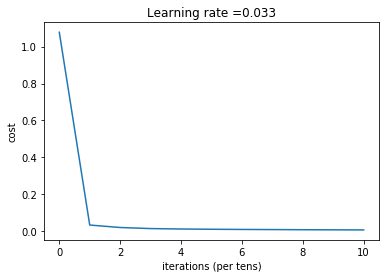

In [11]:
parameters = L_layer_model(X_train, Y_train, layer_dims, .033, 0, 100001, True)
# iris .001 ?
# spiral .033
# wine .001 700001

In [12]:
# p = predict(X_cv, Y_cv, parameters)
# print('p.shape', p.shape)

In [13]:
p = predict(X_test, Y_test, parameters)
print('p.shape', p.shape)

X (2, 2714) Y.shape (3, 2714)
probas
 (3, 2714)
<class 'numpy.ndarray'>
Accuracy: 0.9985261606484893
p.shape (3, 2714)


In [14]:
p_train = predict(X_train, Y_train, parameters)
print('p.shape', p.shape)

X (2, 6286) Y.shape (3, 6286)
probas
 (3, 6286)
<class 'numpy.ndarray'>
Accuracy: 0.9976137448297805
p.shape (3, 2714)


In [15]:
# programmatic gradient checking
# unit tests
# regularization